## Performance Modeling

Models give is a conceptual and roughly quantitative framework by which to answer the following types of questions.

* Why is an implementation exhibiting its observed performance?
* How will performance change if we:
  * optimize this component?
  * buy new hardware? (Which new hardware?)
  * run a different configuration?
* While conceptualizing a new algorithm, what performance can we expect and what will be bottlenecks?

Models are a guide for performance, but not an absolute.

### Terms

| Symbol | Meaning |
|--------|---------|
| $n$    | Input parameter related to problem size |
| $W$    | Amount of work to solve problem $n$ |
| $T$    | Execution time |
| $R$    | Rate at which work is done |

#### STREAM Triad

```c
for (i=0; i<n; i++)
    a[i] = b[i] + scalar*c[i];
```
$n$ is the array size and
$$W = 3 \cdot \texttt{sizeof(double)} \cdot n$$
is the number of bytes transferred.  The rate $R = W/T$ is measured in bytes per second (or MB/s, etc.).

#### Dense matrix multiplication
To perform the operation $C \gets C + A B$ where $A,B,C$ are $n\times n$ matrices.
```c
for (i=0; i<n; i++)
    for (j=0; j<n; j++)
        for (k=0; k<n; k++)
            c[i*n+j] += a[i*n+k] * b[k*n+j];
```

* Can you identify two expressions for the total amount of work $W(n)$ and the associated units?
* Can you think of a context in which one is better than the other and vice-versa?

### Estimating time

To estimate time, we need to know how fast hardware executes flops and moves bytes.

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
import numpy as np
plt.style.use('seaborn')

hardware = pandas.read_csv('data-intel.csv', index_col="Name")
hardware

,Year,GFLOPs-SP,GFLOPs-DP,Cores,Mem-GBps,TDP,Freq(MHz)
Name,,,,,,,
Xeon X5482,2007,102,51,4,26,150,3200
Xeon X5492,2008,108,54,4,26,150,3400
Xeon W5590,2009,106,53,4,32,130,3300
Xeon X5680,2010,160,80,6,32,130,3300
Xeon X5690,2011,166,83,6,32,130,3470
Xeon E5-2690,2012,372,186,8,51,135,2900
Xeon E5-2697 v2,2013,518,259,12,60,130,2700
Xeon E5-2699 v3,2014,1324,662,18,68,145,2300
Xeon E5-2699 v3,2015,1324,662,18,68,145,2300


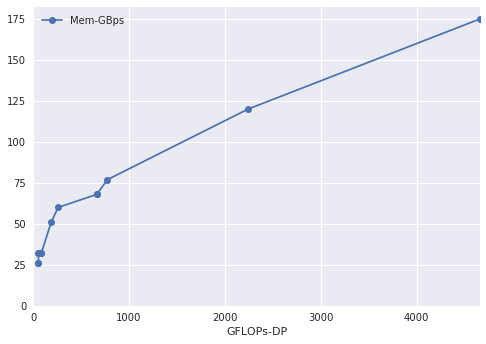

In [16]:
fig = hardware.plot(x='GFLOPs-DP', y='Mem-GBps', marker='o')
fig.set_xlim(left=0)
fig.set_ylim(bottom=0);

So we have rates $R_f = 4660 \cdot 10^9$ flops/second and $R_m = 175 \cdot 10^9$ bytes/second.  Now we need to characterize some algorithms.

In [63]:
algs = pandas.read_csv('algs.csv', index_col='Name')
algs['intensity'] = algs['flops'] / algs['bytes']
algs = algs.sort_values('intensity')
algs

,bytes,flops,intensity
Name,,,
Triad,24,2,0.083333
SpMV,12,2,0.166667
Stencil27-cache,24,54,2.250000
MatFree-FEM,2376,15228,6.409091
Stencil27-ideal,8,54,6.750000


In [48]:
def exec_time(machine, alg, n):
    bytes = n * alg.bytes
    flops = n * alg.flops
    T_mem = bytes / (machine['Mem-GBps'] * 1e9)
    T_flops = flops / (machine['GFLOPs-DP'] * 1e9)
    return max(T_mem, T_flops)
    
exec_time(hardware.loc['Xeon Platinum 9282'], algs.loc['SpMV'], 1e8)

0.006857142857142857

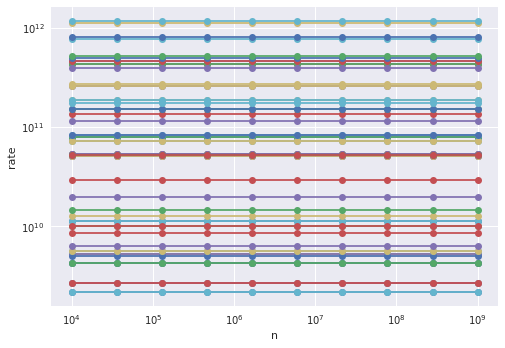

In [64]:
for _, machine in hardware.iterrows():
    for _, alg in algs.iterrows():
        ns = np.geomspace(1e4, 1e9, 10)
        times = np.array([exec_time(machine, alg, n) for n in ns])
        flops = np.array([alg.flops * n for n in ns])
        rates = flops/times
        plt.loglog(ns, rates, 'o-')
plt.xlabel('n')
plt.ylabel('rate');

It looks like performance does not depend on problem size.

Well, yeah, we chose a model in which flops and bytes were both proportional to $n$, and our machine model has no sense of cache hierarchy or latency, so time is also proportional to $n$.  We can divide through by $n$ and yield a more illuminating plot.

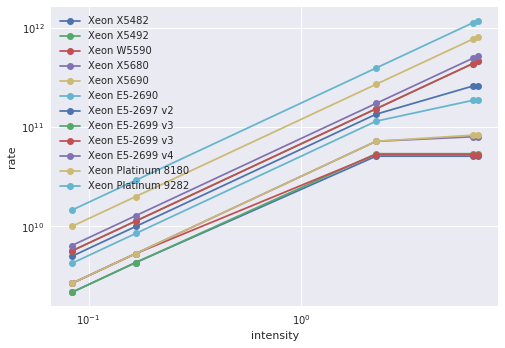

In [68]:
for _, machine in hardware.iterrows():
    times = np.array([exec_time(machine, alg, 1) 
                      for _, alg in algs.iterrows()])
    rates = algs.flops/times
    intensities = algs.intensity
    plt.loglog(intensities, rates, 'o-', label=machine.name)
plt.xlabel('intensity')
plt.ylabel('rate')
plt.legend();

We're seeing the "roofline" for the older processors while the newer models are memory bandwidth limited for all of these algorithms.

### Recommended reading on single-node performance modeling
* [Williams, Waterman, Patterson (2009): **Roofline: An insightful visual performance model for multicore architectures**](https://doi.org/10.1145/1498765.1498785)